# Episodes Sentiment Analysis    Made by: Abdallah Ibrahim CU1900008

This notebook contains the code for my Big Data project and will be doing a sentiment analysis based on the textual reviews for each episode. The data was queried from hive to get the reviews which had more than 2000 votes, as they could be seen as more reliable reviews.

The first step is to import the necessary libraries which will be needed for us to pre process the data and get the sentiment for the review.

In [1]:
import pandas as pd
import string
import matplotlib.pyplot as plt
%matplotlib inline  
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv("queriedData.csv")
df

,rank,show_name,episode_name,watchtime_min,year_of_release,episode_rating,votes,genre_1,genre_2,genre_3,episode_review
0,5,Shingeki no Kyojin,Hero,24.0,2019,9.9,88623,Animation,Action,Adventure,"I haven't seen every episode in the world, but..."
1,6,Shingeki no Kyojin,Perfect Game,24.0,2019,9.9,48614,Animation,Action,Adventure,"Erwin's masterplan is revealed, but at a cost...."
2,7,Mr. Robot,407 Proxy Authentication Required,56.0,2019,9.9,26916,Crime,Drama,Thriller,NaN
3,8,Shingeki no Kyojin,Senshi,24.0,2017,9.9,31103,Animation,Action,Adventure,Everything changes in this episode. Everything...
4,13,Game of Thrones,The Winds of Winter,68.0,2016,9.9,143317,Action,Adventure,Drama,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10006,"32,183",Yakusoku no Neverland,Episode #2.11,23.0,2021,2.7,2425,Animation,Action,Adventure,What is this? 18 minutes of talking and 2 minu...
10007,"32,184",House of Cards,Chapter 73,55.0,2018,2.6,7501,Drama,NaN,NaN,Never in the history of television has a show ...
10008,"32,188",The Wonderful World of Disney,Home Alone 4: Taking Back the House,84.0,2002,2.5,35685,Adventure,Comedy,Drama,NaN
10009,"32,190",Top Gear,Episode #23.1,63.0,2016,2.2,3179,Adventure,Comedy,Reality-TV,NaN


After reading our data and viewing the head, it is noticeable that some episodes have no reviews, so the next step is to drop all the records which have null values as they will have no sentiment.

In [3]:
df1=df[['show_name','episode_name','episode_rating','episode_review']].dropna()
df1.reset_index(drop=True, inplace=True)
df1

,show_name,episode_name,episode_rating,episode_review
0,Shingeki no Kyojin,Hero,9.9,"I haven't seen every episode in the world, but..."
1,Shingeki no Kyojin,Perfect Game,9.9,"Erwin's masterplan is revealed, but at a cost...."
2,Shingeki no Kyojin,Senshi,9.9,Everything changes in this episode. Everything...
3,Breaking Bad,Ozymandias,9.9,'Breaking Bad' is one of the most popular rate...
4,Shingeki no Kyojin,"From You, 2000 Years Ago",9.9,What can I say except HOLY SHT?!I thought at f...
...,...,...,...,...
7801,Riverdale,Chapter Seventy-Four: Wicked Little Town,3.6,"It's not as good as the Heathers special, but ..."
7802,Star Trek: The Next Generation,Shades of Gray,3.4,"\Shades of Gray\"" is a pathetic excuse for an ..."
7803,Yakusoku no Neverland,Episode #2.11,2.7,What is this? 18 minutes of talking and 2 minu...
7804,House of Cards,Chapter 73,2.6,Never in the history of television has a show ...


## Preprocessing 

Now that the data is ready, the preprocessing phase is

##### Before preprocessing

In [4]:
df['episode_review'][1]

"Erwin's masterplan is revealed, but at a cost. It was sad to see that casualties had to be sacrificed in order to win the war, but isn't that what wars are about? As Erwin and Levi both agreed on, it was inevitable that there would be so many casualties. This was a near-perfect episode with a flawless cliffhanger."

In [5]:
# change data type to string
df1['episode_review'] = df1['episode_review'].astype(str)

# lowercase the reviews
df1['episode_review'] = df1['episode_review'].apply(lambda x: " ".join(x.lower() for x in x.split()))


In [6]:
# remove the punctuation

df1['episode_review'] = df1['episode_review'].str.replace('[^\w\s]','')

In [7]:
# remove stop words

stop = stopwords.words('english')
df1['episode_review'] = df1['episode_review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [8]:
# Stemming

st = PorterStemmer()
df1['episode_review'] = df1['episode_review'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

##### After preprocessing

In [9]:
df1['episode_review'][1]

'erwin masterplan reveal cost sad see casualti sacrif order win war isnt war erwin levi agre inevit would mani casualti nearperfect episod flawless cliffhang'

## Sentiment Score

In [10]:
def percentage(part,whole):
    return 100 * float(part)/float(whole)

In [11]:
def senti(x):
    return TextBlob(x).sentiment.polarity

def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

df1['sentiment_polarity'] = df1['episode_review'].apply(senti)

df1['sentiment_score'] = df1['sentiment_polarity'].apply(getAnalysis)




In [12]:
positive = 0
negative = 0
neutral = 0
review_list = []
neutral_list = []
negative_list = []
positive_list = []

In [13]:
df1

,show_name,episode_name,episode_rating,episode_review,sentiment_polarity,sentiment_score
0,Shingeki no Kyojin,Hero,9.9,havent seen everi episod world close perfect e...,0.245707,Positive
1,Shingeki no Kyojin,Perfect Game,9.9,erwin masterplan reveal cost sad see casualti ...,0.433333,Positive
2,Shingeki no Kyojin,Senshi,9.9,everyth chang episod everyth prais last episod...,0.075000,Positive
3,Breaking Bad,Ozymandias,9.9,break bad one popular rate show imdb one rarit...,0.206410,Positive
4,Shingeki no Kyojin,"From You, 2000 Years Ago",9.9,say except holi shti thought first episod move...,0.172673,Positive
...,...,...,...,...,...,...
7801,Riverdale,Chapter Seventy-Four: Wicked Little Town,3.6,good heather special nice see show way actor s...,-0.034719,Negative
7802,Star Trek: The Next Generation,Shades of Gray,3.4,shade gray pathet excus episod star trek next ...,-0.350000,Negative
7803,Yakusoku no Neverland,Episode #2.11,2.7,18 minut talk 2 minut actual event yet know cu...,-0.133333,Negative
7804,House of Cards,Chapter 73,2.6,never histori televis show resembl larg pack c...,-0.140128,Negative


In [14]:
for i in range (df1.shape[0]):
    review_list.append(df1['episode_review'][i])
    if df1['sentiment_score'][i] == 'Positive':
        positive_list.append(df1['episode_review'][i])
        positive += 1
    elif df1['sentiment_score'][i] == 'Negative':
        negative_list.append(df1['episode_review'][i])
        negative += 1
    else:
        neutral_list.append(df1['episode_review'][i])
        neutral += 1

In [15]:
positive = percentage(positive, df1.shape[0])
negative = percentage(negative, df1.shape[0])
neutral = percentage(neutral, df1.shape[0])
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')

In [16]:
review_list = pd.DataFrame(review_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print("total number: ",len(review_list))
print("positive number: ",len(positive_list))
print("negative number: ", len(negative_list))
print("neutral number: ",len(neutral_list))

total number:  7806
positive number:  6044
negative number:  1360
neutral number:  402


In [27]:
words_to_exclude = ["episode", "show", "season", "episod", "charact", "one", "stori"]

def create_wordcloud(text):
    #mask = np.array(Image.open("cloud.png"))
    stopwords = set(STOPWORDS)
    cleaned_word = " ".join([word for word in text.split()
                            if all(ele not in word for ele in words_to_exclude)])
    wc = WordCloud(
    #mask = mask,
    max_words=3000,
    min_word_length =3,
    collocation_threshold = 20,
    stopwords=stopwords,
    repeat=True)
    wc.generate(cleaned_word)
    
    return wc

#### Creating piechart

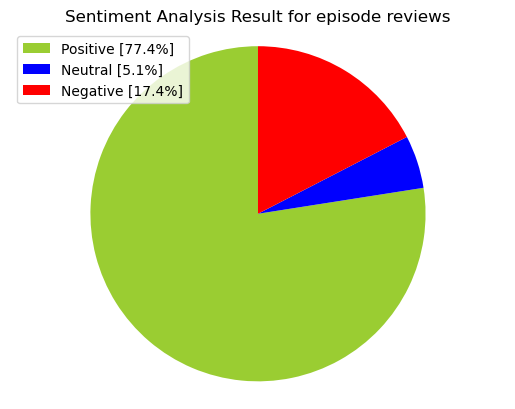

In [28]:
labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for episode reviews" )
plt.axis('equal')
plt.show()

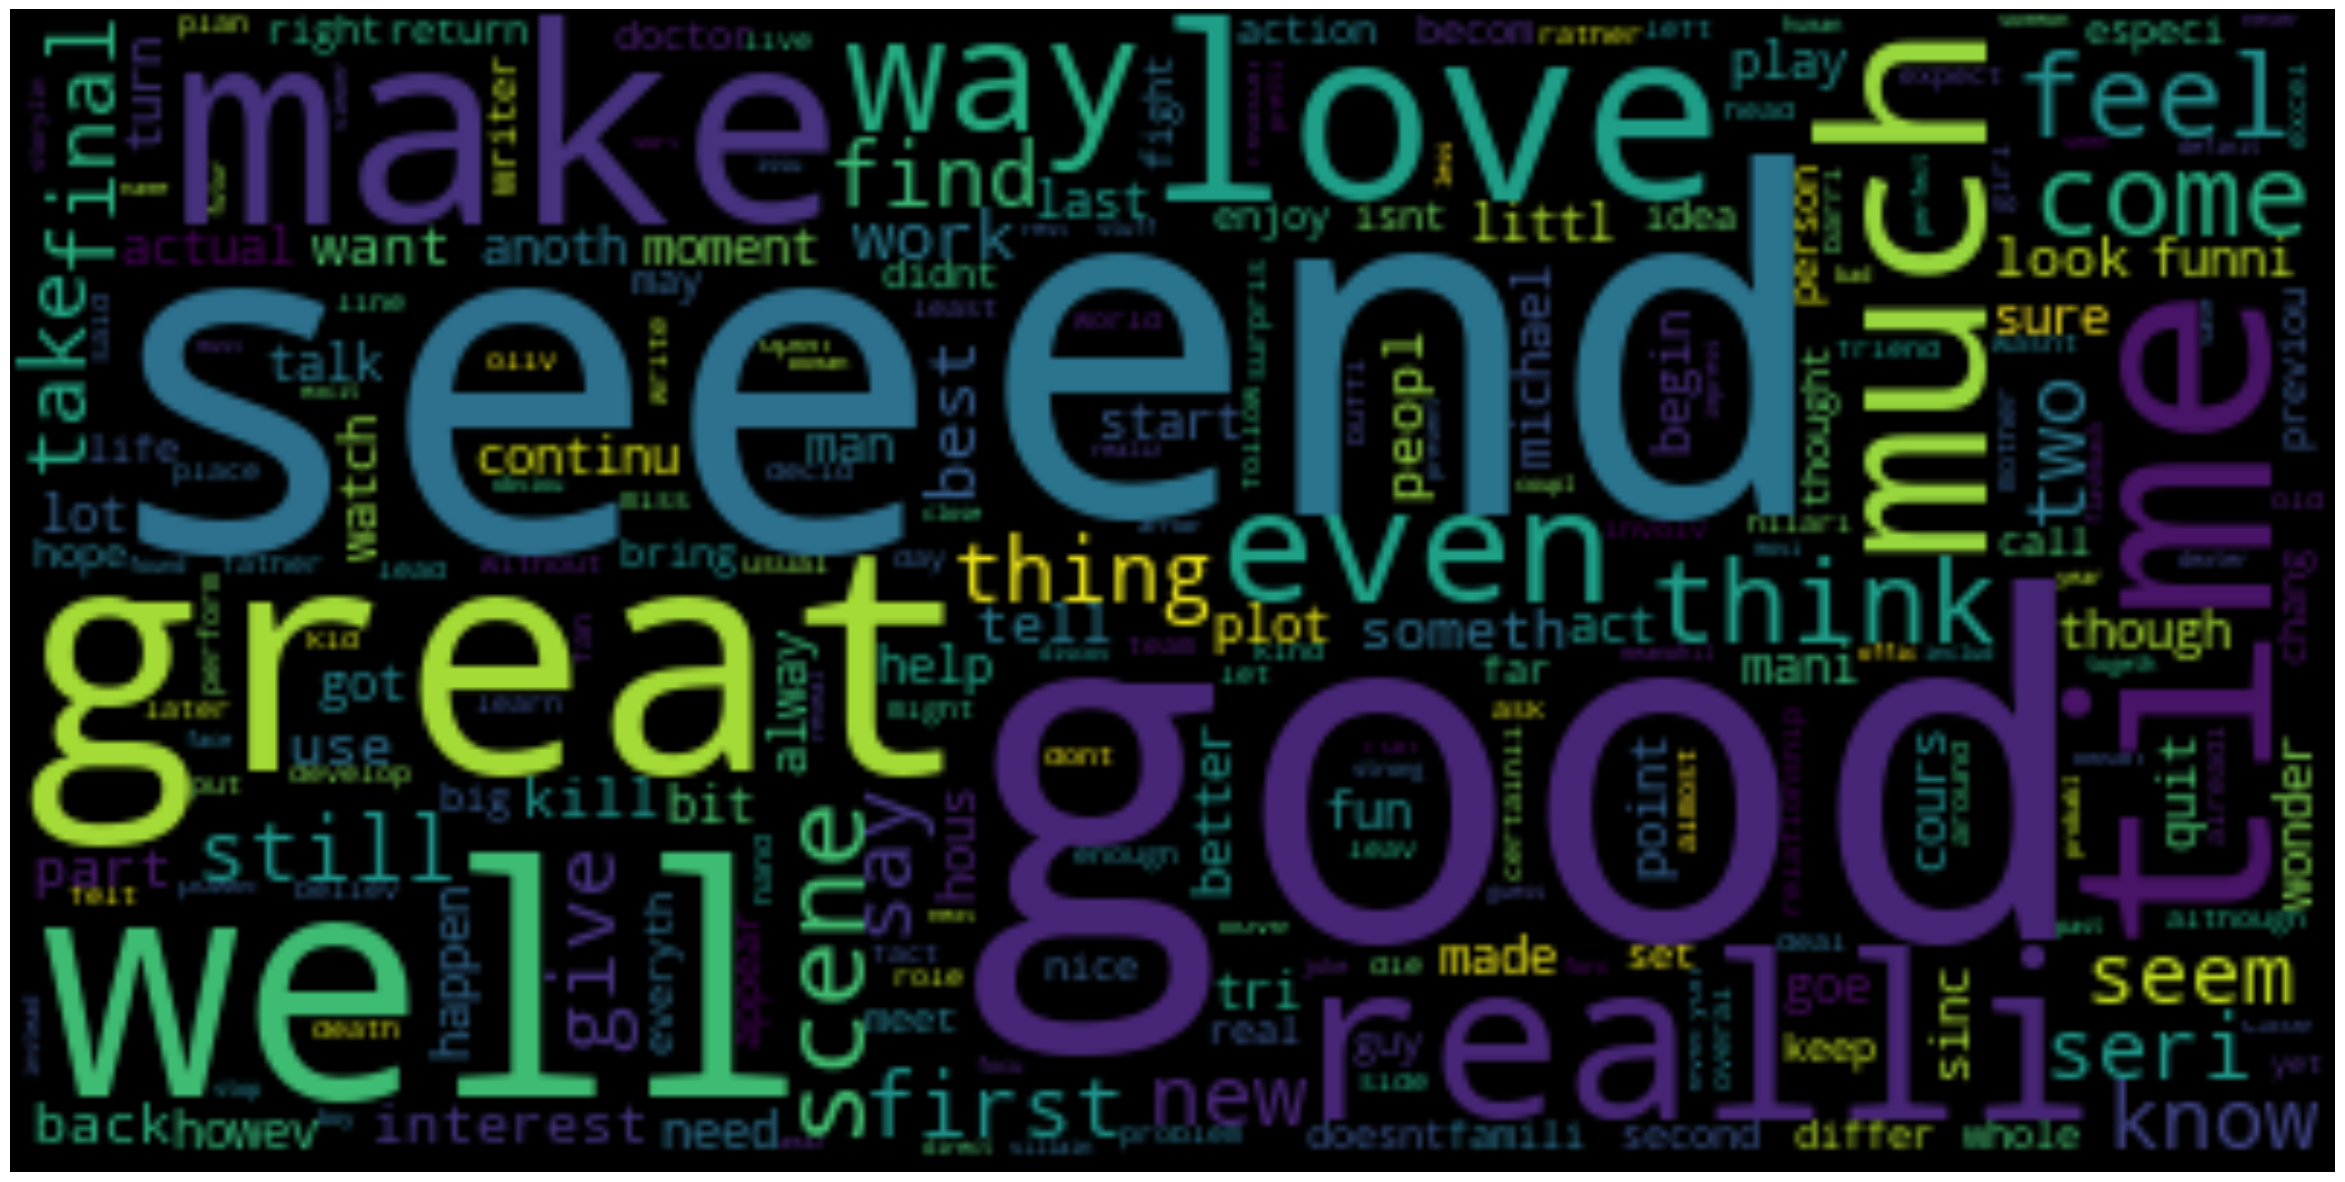

In [29]:
wordcloud = create_wordcloud(' '.join(positive_list[0]))
fig = plt.figure(1,figsize=(30, 50))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

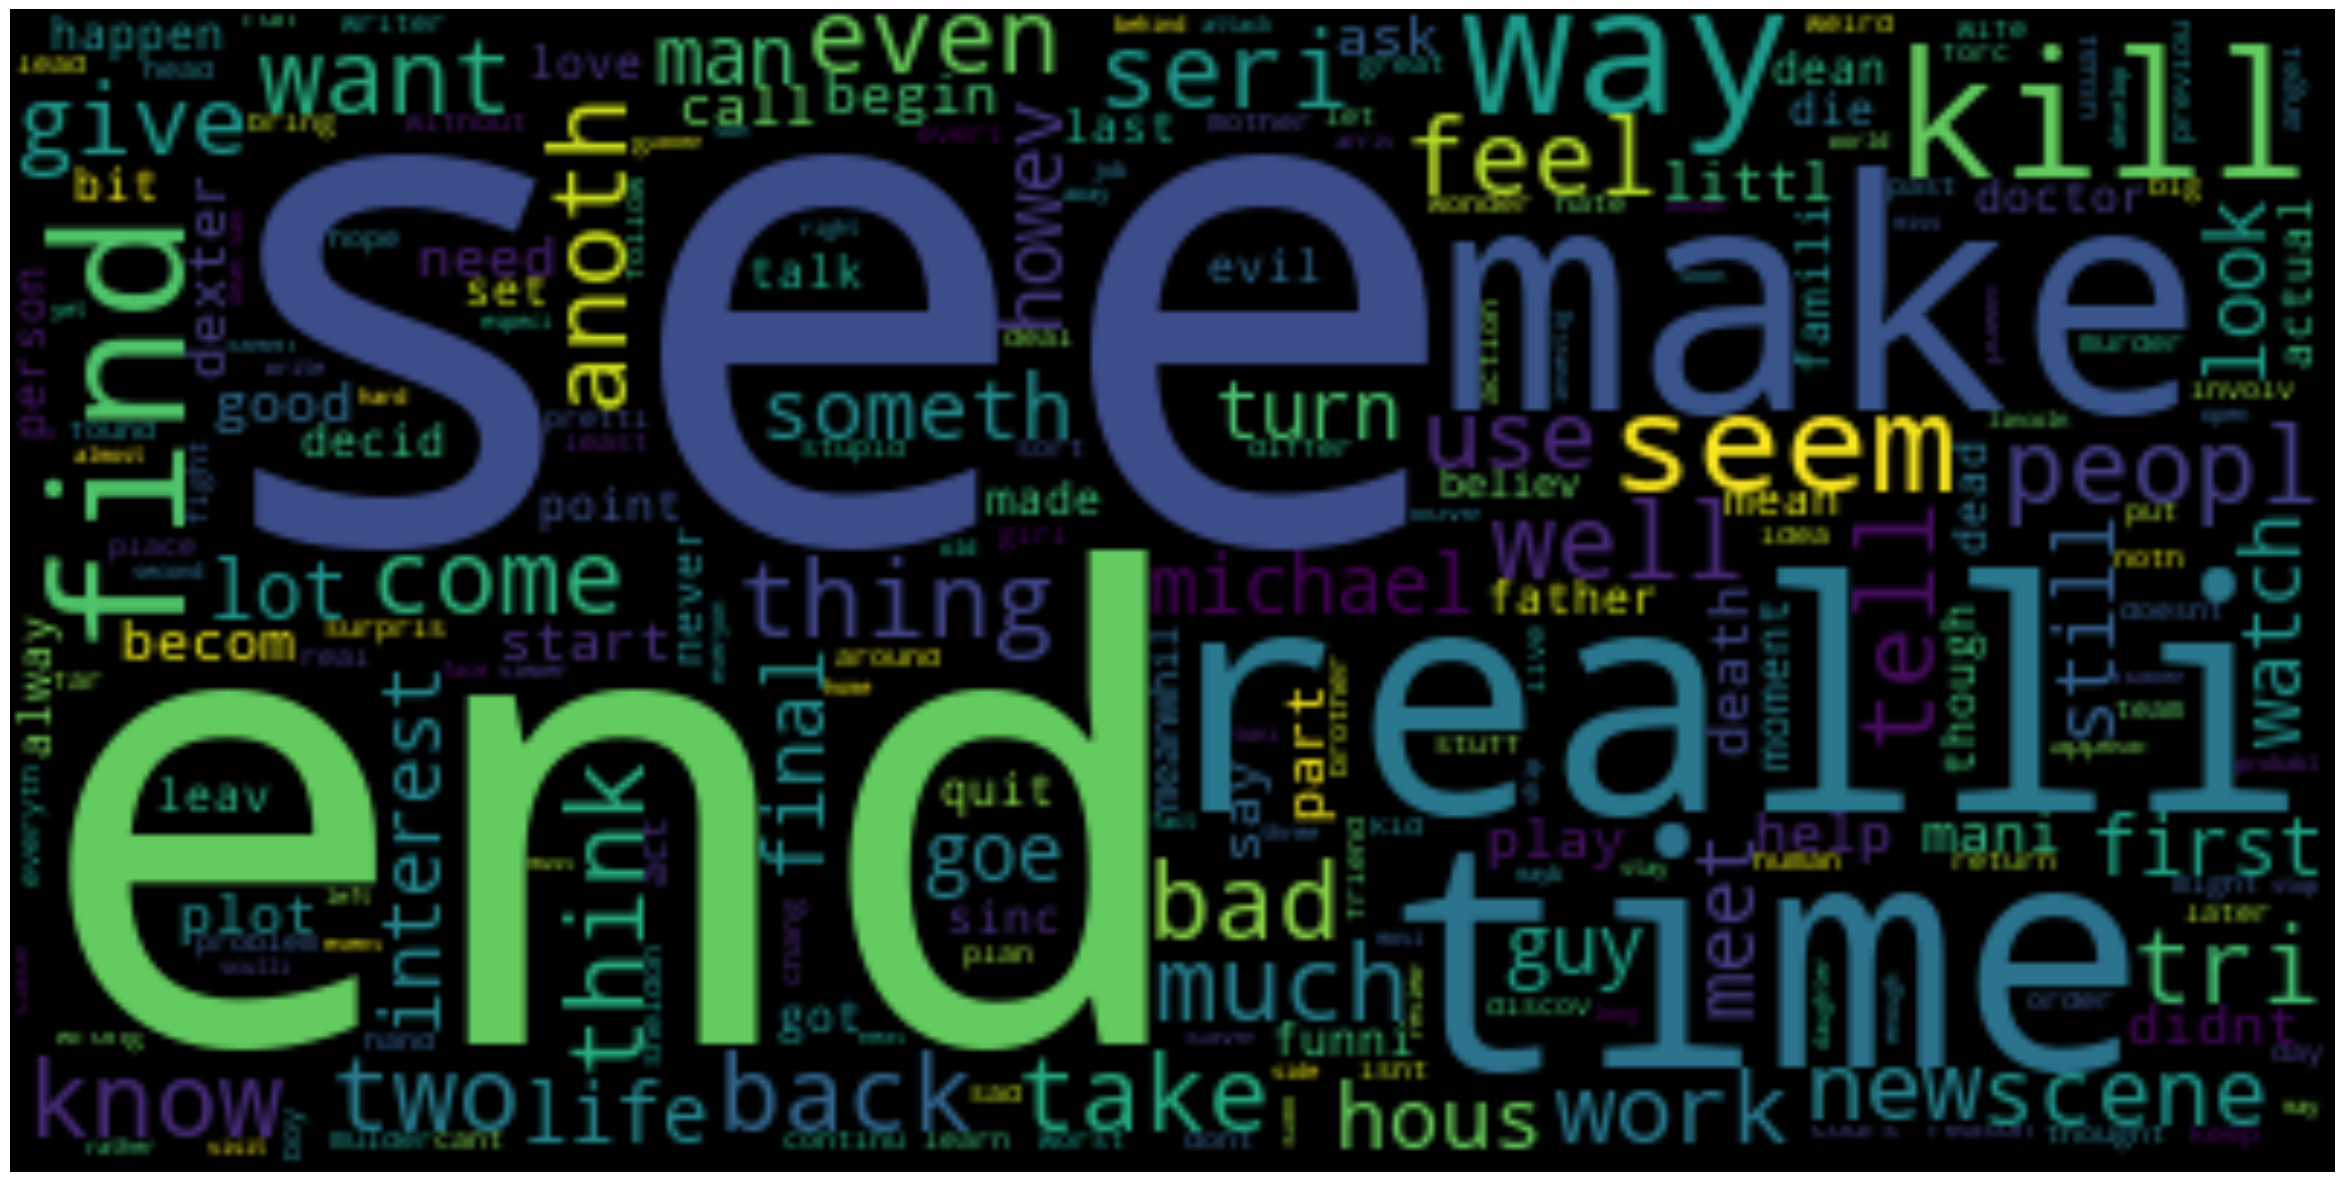

In [30]:
wordcloud = create_wordcloud(' '.join(negative_list[0]))
fig = plt.figure(1,figsize=(30, 50))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [31]:
# create a dictionary of word frequencies
text = ' '.join(negative_list[0])
text_dictionary = wordcloud.process_text(text)
# sort the dictionary
word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}

#use words_ to print relative word frequencies
rel_freq = wordcloud.words_

#print results
print("Most frequent words")
print(list(word_freq.items())[0:50])
print("Least frequent words")
print(list(word_freq.items())[-100:-50])

Most frequent words
[('episod', 1108), ('one', 689), ('show', 643), ('charact', 407), ('see', 386), ('end', 349), ('realli', 345), ('stori', 338), ('time', 311), ('way', 308), ('make', 306), ('find', 293), ('kill', 271), ('seem', 266), ('season', 252), ('even', 245), ('thing', 244), ('come', 242), ('want', 240), ('well', 229), ('think', 225), ('peopl', 223), ('take', 222), ('know', 218), ('back', 217), ('seri', 217), ('tri', 212), ('bad', 204), ('anoth', 203), ('much', 199), ('feel', 196), ('use', 195), ('tell', 195), ('give', 193), ('work', 190), ('two', 189), ('scene', 187), ('someth', 186), ('hous', 186), ('new', 183), ('michael', 182), ('interest', 177), ('look', 176), ('man', 174), ('still', 164), ('howev', 164), ('lot', 163), ('watch', 159), ('life', 157), ('turn', 155)]
Least frequent words
[('unforsaken ductwork', 1), ('speci passionflow', 1), ('passionflow teliko', 1), ('pituitari gland', 1), ('eugen victor', 1), ('victor toom', 1), ('rhoadesa weaselli', 1), ('graduat petti', 